In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


import datetime
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
import sys


In [ ]:
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /home/maai8912/.cache/torch/hub/torchhub.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/maai8912/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [2]:

def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]


def generate_label(obj):
    if obj.find('name').text == "with_mask": 
        return 2 
    elif obj.find('name').text == "mask_weared_incorrect": 
        return 3 
    return 1

# def generate_label(obj):
#     if obj.find('name').text == "with_mask":
#         return 1
#     elif obj.find('name').text == "mask_weared_incorrect":
#         return 2
#     return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target


In [3]:
imgs = list(sorted(os.listdir("dataset/images")))

In [4]:
labels = list(sorted(os.listdir("dataset/annotations/")))

In [5]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir("dataset/images/")))
#         self.labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("dataset/images/", file_image)
        label_path = os.path.join("dataset/annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [39]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [40]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
samples = []

for i in range(len(dataset)):
    samples.append(dataset[i])

    
# REMOVE THE BELOW STATEMENT
# samples = samples[:10]
    
train_size = int(0.9*len(samples))
samples_train = samples[:train_size]
samples_val = samples[train_size:]

train_data_loader = torch.utils.data.DataLoader(
 samples_train, batch_size=2, collate_fn=collate_fn)

val_data_loader = torch.utils.data.DataLoader(
 samples_val, batch_size=2, collate_fn=collate_fn)

In [41]:
len(train_data_loader)

384

In [42]:
torch.cuda.is_available()

True

# Model

In [43]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)

    return model

In [44]:
model = get_model_instance_segmentation(3)

In [45]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# for imgs, annotations in data_loader:
#     imgs = list(img.to(device) for img in imgs)
#     annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
#     print(annotations)
#     break

# Train Model

In [46]:
def get_filename(time: int, util_name:str =""):   
    filename = str(time.strftime('%b-%d-%Y_%H-%M-%S'))
    if util_name != "":
        filename = util_name+"_"+filename
    return filename

In [ ]:
time = datetime.datetime.now()
saves_dir = os.path.join('saves', get_filename(time))
Path(saves_dir).mkdir(parents=True, exist_ok=True)

summ_filename = os.path.join(saves_dir,'tensorboard_summary')
writer = SummaryWriter(summ_filename)

num_epochs = 10
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_train_dataloader = len(train_data_loader)

best_val_loss = sys.maxsize
best_epoch = -1

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = []
    val_epoch_loss = []
    print("Epoch:", epoch)
    
    model.train()
    
    for imgs, annotations in train_data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
#         print("train:", loss_dict)
        
        # loss_dict consists of multiple losses such as classification loss, bounding box loss, and two other losses.
        losses = sum([loss for loss in loss_dict.values()])

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()         
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')

        epoch_loss.append(losses.detach().cpu().numpy())
    
    with torch.no_grad():
        for imgs, annotations in val_data_loader:
#             print(len(imgs), len(annotations))
            imgs = list(img.to(device) for img in imgs)
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
            loss_dict = model(imgs, annotations)
#             print(len(loss_dict))
#             print("val:",loss_dict)

            losses = sum([loss for loss in loss_dict.values()])

            val_epoch_loss.append(losses.detach().cpu().numpy())
    
    torch.save(model.state_dict(),os.path.join(saves_dir, 'model_'+str(epoch)+'_epochs.pt'))
    avg_epoch_loss = np.mean(epoch_loss)
    avg_val_epoch_loss = np.mean(val_epoch_loss)
    writer.add_scalars("losses", {
        "avg_training_loss": avg_epoch_loss,
        "avg_val_loss": avg_val_epoch_loss
    }, epoch)
#     writer.add_scalar("avg_val_loss", avg_val_epoch_loss, epoch)
    
    print("Avg training loss:", avg_epoch_loss)
    print("Avg validation loss:", avg_val_epoch_loss)
    
    
    if avg_val_epoch_loss<best_val_loss:
        best_val_loss=avg_val_epoch_loss
        best_epoch = epoch
        
print("===================================")        
print("Best model details:")
print("Epoch:", best_epoch)
print("Min validation loss:", best_val_loss)

Epoch: 0
Avg training loss: 0.2958584
Avg validation lossL: 0.28894126
Epoch: 1
Avg training loss: 0.17449598
Avg validation lossL: 0.19461556
Epoch: 2
Avg training loss: 0.13323891
Avg validation lossL: 0.20225239
Epoch: 3
Avg training loss: 0.11160345
Avg validation lossL: 0.21629266
Epoch: 4
Avg training loss: 0.09816589
Avg validation lossL: 0.20024818
Epoch: 5
Avg training loss: 0.08738344
Avg validation lossL: 0.20263499
Epoch: 6


In [ ]:
# for imgs, annotations in data_loader:
#         imgs = list(img.to(device) for img in imgs)
#         annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
#         break

In [ ]:
# model.eval()
# preds = model(imgs)
# preds

# Function to plot image

In [13]:
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

In [14]:
def plot_image_new(img_tensor, annotation, block=True):
    print(annotation)
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data
    # Display the image
    ax.imshow( np.array( img.permute(1, 2, 0) ) )

    for box, label in zip( annotation["boxes"], annotation["labels"] ):
        print("label",label)
        print("box",box)
        xmin, ymin, xmax, ymax = box
        # Create a Rectangle patch
        if label==1:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='b',facecolor='none')
        else:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        ax.axis("off")
    plt.show(block=block)

In [15]:
# print("Prediction")
# plot_image(imgs[2], preds[2])
# print("Target")
# plot_image(imgs[2], annotations[2])

In [43]:
torch.save(model.state_dict(),'model.pt')

In [15]:
model2 = get_model_instance_segmentation(3)

# Save Model

In [16]:
model2.load_state_dict(torch.load('model_15_epochs.pt'))
model2.eval()
model2.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

# Load Model

In [17]:
pred2 = model2(imgs)

Predict with loaded model


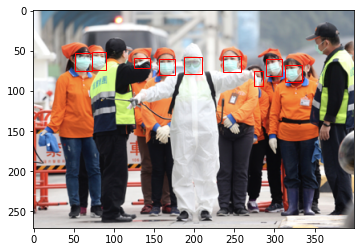

In [18]:
print("Predict with loaded model")
plot_image(imgs[3], pred2[3])

In [39]:
img_path = "sample_images/sample_input_wo_mask.jpg"
# label_path = os.path.join("dataset/annotations/", file_label)
img_sample_input = Image.open(img_path).convert("RGB")
#Generate Label
# target = generate_target(idx, label_path)

if data_transform is not None:
    img_sample_input = data_transform(img_sample_input)

In [40]:
# img_sample_input = torch.unsqueeze(img_sample_input, 0).to(device)
# img_sample_input.shape

torch.Size([1, 3, 720, 1080])

In [41]:
img_sample_input = torch.unsqueeze(img_sample_input, 0).to(device)
pred_sample_input = model2(img_sample_input)

Predict sample image with loaded model


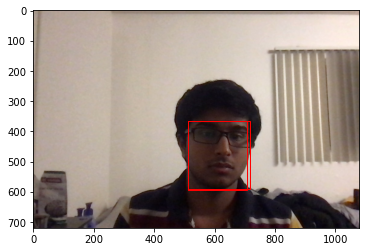

In [42]:
print("Predict sample image with loaded model")
plot_image(img_sample_input[0], pred_sample_input[0])

In [25]:
# img_path = "sample_images/sample_input_wo_mask.jpg"
img_path = "sample_images/mask_only_2.jpg"
# img_path = "sample_images/3.jpg"
# label_path = os.path.join("dataset/annotations/", file_label)
img_sample_input = Image.open(img_path).convert("RGB")
print(img_sample_input.size)
#Generate Label
# target = generate_target(idx, label_path)

if data_transform is not None:
    img_sample_input = data_transform(img_sample_input)
    
img_sample_input = torch.unsqueeze(img_sample_input, 0).to(device)
print(img_sample_input.shape)

(1080, 720)
torch.Size([1, 3, 720, 1080])


Predict sample image with loaded model
{'boxes': tensor([[857.6069, 719.8705, 859.1973, 719.9999],
        [857.5978, 719.8700, 859.1827, 720.0000],
        [857.5965, 719.8708, 859.1927, 720.0000]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 3, 2], device='cuda:0'), 'scores': tensor([0.1748, 0.1663, 0.1601], device='cuda:0', grad_fn=<IndexBackward>)}
label tensor(1, device='cuda:0')
box tensor([857.6069, 719.8705, 859.1973, 719.9999], device='cuda:0',
       grad_fn=<SelectBackward>)
label tensor(3, device='cuda:0')
box tensor([857.5978, 719.8700, 859.1827, 720.0000], device='cuda:0',
       grad_fn=<SelectBackward>)
label tensor(2, device='cuda:0')
box tensor([857.5965, 719.8708, 859.1927, 720.0000], device='cuda:0',
       grad_fn=<SelectBackward>)


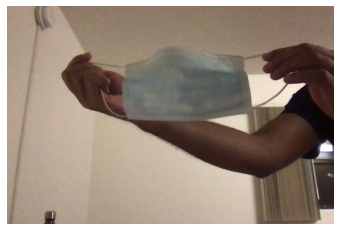

In [28]:
model3 = get_model_instance_segmentation(3)
model3.load_state_dict(torch.load('saves/Nov-30-2020_06-04-59/model_10_epochs.pt'))
model3.eval()
model3.to(device)
pred_sample_input = model3(img_sample_input)

print("Predict sample image with loaded model")
plot_image_new(img_sample_input[0], pred_sample_input[0])